In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

In [26]:
'''
Purpose: This class represents a single module in the song bird system, aka HVC or RA
'''

class SpikingModule():
    def __init__(self, neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant):
        '''
        Purpose:
        - the input matrix is the matrix of weights from the input to the neurons in the module  
        - the internal connectivity matrix is the matrix of weights from the neurons in the module to the neurons in the module  
        - the neuron states is a vector of the current state of each neuron in the module (membrane potential)
        - the clock is the current time step of the module
        - the firing history is a list of the time steps at which each neuron fired
        '''
        self.input_matrix = np.random.rand(input_count, neuron_count)
        self.internal_connectivity_matrix = np.random.rand(neuron_count, neuron_count)
        self.neuron_states = np.random.rand(neuron_count)
        self.output_weights = np.random.rand(neuron_count, output_count)
        self.clock = 0
        self.firing_history = []
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.time_constant = time_constant
        self.threshold = threshold

        # Initialize freeze masks for input, intra, and output weights
        self.input_freeze_mask = np.zeros_like(self.input_matrix, dtype=bool)
        self.intra_freeze_mask = np.zeros_like(self.internal_connectivity_matrix, dtype=bool)
        self.output_freeze_mask = np.zeros_like(self.output_weights, dtype=bool)

    def stdp(self, learning_rate, time_constant):
        """
        Purpose:
        - Implement Spike-Timing-Dependent Plasticity (STDP) learning rule to update weights of the internal_connectivity_matrix.
        Args:
        - learning_rate (float): The rate at which the weights should be updated.
        - time_constant (float): The time constant for the STDP.
        """

        for i in range(len(self.internal_connectivity_matrix)):
            for j in range(len(self.internal_connectivity_matrix[i])):
                if i == j or self.intra_freeze_mask[i, j]:
                    continue

                last_spike_i = self._find_last_spike(i)
                last_spike_j = self._find_last_spike(j)

                if last_spike_i is not None and last_spike_j is not None:
                    delta_t = self.clock - last_spike_i - last_spike_j
                    if delta_t > 0:
                        self.internal_connectivity_matrix[i][j] += learning_rate * np.exp(-delta_t / time_constant)
                    elif delta_t < 0:
                        self.internal_connectivity_matrix[i][j] -= learning_rate * np.exp(delta_t / time_constant)

        self.internal_connectivity_matrix = np.clip(self.internal_connectivity_matrix, -1, 1)

    def _find_last_spike(self, neuron_index):
        '''
        Purpose:
        - Find the last time step at which the specified neuron fired.

        Args:
        - neuron_index (int): The index of the neuron in question.

        Returns:
        - last_spike (int or None): The time step of the last spike for the specified neuron, or None if the neuron has not fired.
        '''
        last_spike = None
        for time_step, fired_neurons in enumerate(reversed(self.firing_history)):
            if np.isin(neuron_index, fired_neurons):
                last_spike = self.clock - time_step - 1
                break
        return last_spike


    def step(self, input):
        self.neuron_states = self.neuron_states + self.internal_connectivity_matrix.dot(self.neuron_states) + self.input_matrix.T.dot(input)
        self.neuron_states = self.neuron_states * self.decay_rate
        self.neuron_states[np.where(self.neuron_states < 0)] = 0
        fired_neurons = np.where(self.neuron_states > self.threshold)
        self.firing_history.append(fired_neurons)
        self.neuron_states[fired_neurons] = 0
        self.clock += 1

        # Apply STDP learning rule with the desired learning_rate and time_constant
        learning_rate = 0.01
        time_constant = 20
        self.stdp(learning_rate, time_constant)

    def set_input_weights(self, input_weights):
        '''
        Purpose:
        - Set the input weights for the module.
        Args:
        - input_weights (array-like): The input weights to be set.
        '''
        self.input_matrix = np.array(input_weights)

    def set_internal_weights(self, internal_weights):
        '''
        Purpose:
        - Set the internal weights for the module.
        Args:
        - internal_weights (array-like): The internal weights to be set.
        '''
        self.internal_connectivity_matrix = np.array(internal_weights)

    def get_output(self):
        '''
        Purpose:
        - Compute the output of the module based on the current state of the neurons and the output weights.

        Returns:
        - output (array-like): The output of the module.
        '''
        output = self.output_weights.T.dot(self.neuron_states)
        return output

    def set_input_weights(self, input_weights):
        self.input_matrix = input_weights

    def set_internal_weights(self, internal_weights):
        self.internal_connectivity_matrix = internal_weights

    def set_output_weights(self, output_weights):
        self.output_weights = output_weights

    def visualize_network(self):
        # Create a directed graph
        G = nx.DiGraph()

        # Add neurons as nodes
        for neuron in range(len(self.neuron_states)):
            G.add_node(neuron)

        # Add edges based on internal connectivity matrix
        for i in range(len(self.internal_connectivity_matrix)):
            for j in range(len(self.internal_connectivity_matrix[i])):
                if i == j:
                    continue
                weight = self.internal_connectivity_matrix[i][j]
                G.add_edge(i, j, weight=weight)

        # Plot the network
        pos = nx.spring_layout(G)
        fig, ax = plt.subplots()

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="skyblue", ax=ax)

        # Draw edges with varying thickness based on weights
        for (u, v, d) in G.edges(data=True):
            weight = d['weight']
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=weight * 5, ax=ax)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)


        # Plot the firing history
        plt.figure()
        for i, fired_neurons in enumerate(self.firing_history):
            for neuron in fired_neurons[0]:
                plt.plot(i, neuron, marker='o', markersize=5, linestyle='None')
        plt.xlabel('Time Step')
        plt.ylabel('Neuron Index')
        plt.title('Firing History')
        plt.show()


    def freeze_weights(self, selected_neurons, percent_to_freeze, neurons=None):
        """
        Purpose:
        - Freeze the specified percentage of weights for the selected neurons or specific neurons.
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to freeze.
        - percent_to_freeze (float): The percentage of weights to freeze (between 0 and 1).
        - neurons (list of int, optional): The indices of specific neurons to freeze. If not provided, weights are frozen randomly.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not 0 <= percent_to_freeze <= 1:
            raise ValueError("percent_to_freeze must be between 0 and 1.")

        # Choose the weight matrix based on selected_neurons
        if selected_neurons == 'input':
            weight_matrix = self.input_matrix
        elif selected_neurons == 'intra':
            weight_matrix = self.internal_connectivity_matrix
        else:
            weight_matrix = self.output_weights

        # Create a mask to indicate frozen weights
        freeze_mask = np.zeros_like(weight_matrix, dtype=bool)

        if neurons is not None:
            if not all(isinstance(n, int) for n in neurons):
                raise ValueError("neurons must be a list of integers.")

            # Freeze all weights for the specified neurons
            for neuron_index in neurons:
                if selected_neurons == 'input':
                    freeze_mask[:, neuron_index] = True
                elif selected_neurons == 'intra':
                    freeze_mask[neuron_index, :] = True
                    freeze_mask[:, neuron_index] = True
                else:
                    freeze_mask[neuron_index, :] = True
        else:
            # Calculate the number of weights to freeze
            num_weights_to_freeze = int(np.prod(weight_matrix.shape) * percent_to_freeze)

            # Choose the indices of the weights to freeze
            freeze_indices = np.random.choice(np.arange(weight_matrix.size), num_weights_to_freeze, replace=False)
            freeze_mask.ravel()[freeze_indices] = True

        # Assign the freeze_mask to the corresponding attribute
        if selected_neurons == 'input':
            self.input_freeze_mask = freeze_mask
        elif selected_neurons == 'intra':
            self.intra_freeze_mask = freeze_mask
        else:
            self.output_freeze_mask = freeze_mask

### For Testing the SpikingModule Class

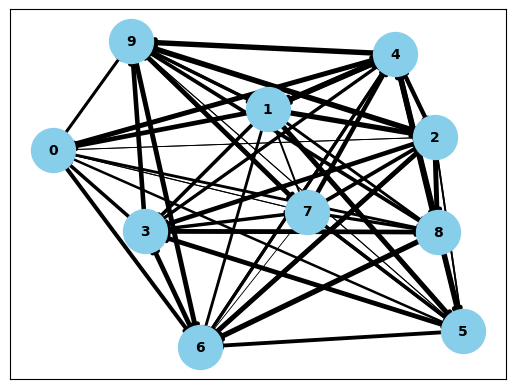

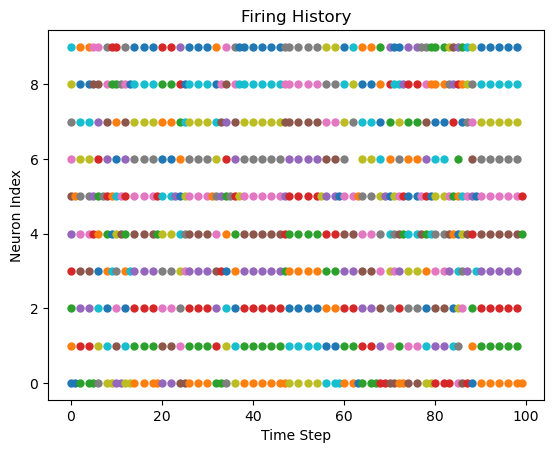

In [27]:
neuron_count = 10
input_count = 5
output_count = 5
decay_rate = 0.5
threshold = 1
learning_rate = 0.01
time_constant = 20

module = SpikingModule(neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant)
module.freeze_weights('input', 0.5)

for _ in range(1000):
    input = np.random.rand(input_count)
    module.step(input)


module.visualize_network()

In [ ]:
HVC = SpikingModule(neuron_count=30, input_count=10, output_count=10, decay_rate=0.99, threshold=1, learning_rate=0.01, time_constant=20)